C:\Users\NorthForest\AppData\Local\Temp\ipykernel_21416\928697589.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  otf = torch.fft.fft2(torch.tensor(psf_pad, dtype=torch.float32, device='cuda'))


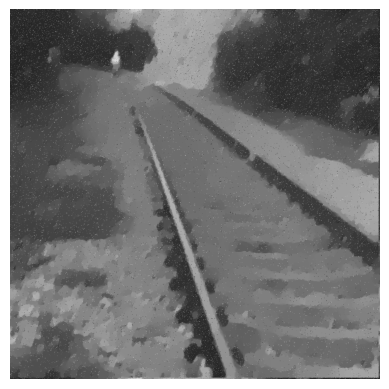

In [39]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt


def psf2otf(psf, shape):
    psf_pad = torch.zeros(shape)
    psf_pad[:psf.shape[0], :psf.shape[1]] = psf
    otf = torch.fft.fft2(torch.tensor(psf_pad, dtype=torch.float32, device='cuda'))
    return otf


def L0Restoration(image, kernel, lambd, kappa=2.0):
    image = torch.tensor(image, dtype=torch.float32, device='cuda')
    kernel = torch.tensor(kernel, dtype=torch.float32, device='cuda')
    # c, h, w = image.shape
    pad_h, pad_w = kernel.shape[0] - 1, kernel.shape[1] - 1
    image_padded = torch.nn.functional.pad(image, (pad_w, pad_w, pad_h, pad_h), mode='reflect')
    # Im_padded = Im

    S = image_padded.clone()
    betamax = 1e5
    fx = torch.tensor([[1, -1]])
    fy = torch.tensor([[1], [-1]])
    C, H, W = image_padded.shape
    otfFx = psf2otf(fx, (H, W))
    otfFy = psf2otf(fy, (H, W))
    kernel_hat = psf2otf(kernel, (H, W)).unsqueeze(0)
    density_kernel = torch.abs(kernel_hat) ** 2
    Denormin2 = torch.abs(otfFx) ** 2 + torch.abs(otfFy) ** 2
    if C >= 1:
        Denormin2 = Denormin2.unsqueeze(0).expand(C, H, W)
        kernel_hat = kernel_hat.expand(C, H, W)
        density_kernel = density_kernel.expand(C, H, W)
    Normin1 = torch.conj(kernel_hat) * torch.fft.fft2(S)

    beta = kappa * lambd
    while beta < betamax:
        Denormin = density_kernel + beta * Denormin2
        h = torch.cat((S[:, :, 1:] - S[:, :, :-1], S[:, :, :1] - S[:, :, -1:]), dim=2)
        v = torch.cat((S[:, 1:, :] - S[:, :-1, :], S[:, :1, :] - S[:, -1:, :]), dim=1)
        t = (h ** 2 + v ** 2).sum(dim=0, keepdim=True) < lambd / beta
        h[t.expand_as(h)] = 0
        v[t.expand_as(v)] = 0
        Normin2 = torch.cat((h[:, :, -1:] - h[:, :, :1], -h[:, :, 1:] + h[:, :, :-1]), dim=2)
        Normin2 += torch.cat((v[:, -1:, :] - v[:, :1, :], -v[:, 1:, :] + v[:, :-1, :]), dim=1)
        FS = (Normin1 + beta * torch.fft.fft2(Normin2)) / Denormin
        S = torch.real(torch.fft.ifft2(FS))
        beta *= kappa

    return S[:, pad_h:pad_h + H, pad_w:pad_w + W].cpu().numpy()


# 示例代码
if __name__ == "__main__":
    # 读取示例图像和卷积核
    img = cv2.imread('example.png').astype(np.float32) / 255.0
    kernel = np.array([[1, 4, 6, 4, 1],
                       [4, 16, 24, 16, 4],
                       [6, 24, 36, 24, 6],
                       [4, 16, 24, 16, 4],
                       [1, 4, 6, 4, 1]]) / 256.0
    img = np.expand_dims(np.loadtxt('image.csv', delimiter=','), 2).transpose(2, 0, 1)
    kernel = np.loadtxt('kernel.csv', delimiter=',')

    img = cv2.imread('example.png').astype(np.float32).mean(axis=2, keepdims=True).transpose(2, 0, 1) / 255.0
    kernel = np.zeros((7, 7))
    kernel[3, 3:4] = 0.5

    # 执行L0去模糊
    lambda_ = 0.02
    result = L0Restoration(img, kernel, 0.02)

    # 显示结果
    plt.imshow(result.transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()